# CPDonkey December Notebook
Notebook detailing the formation of a donkeycar pilot using a Deep CNN and a single input image

In [1]:
##Data Profile

#Image Data Example

#Labels

In [4]:
#IMPORTS
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

The data that is fed into the donkeycar's pilot is a single input image. The donkeycar must be able to determine from this image whether to turn left or right. 

This image is a photo taken by the Donkeycar's front-facing camera with a resolution of 120x160. Each image, when taken, is labeled with a user angle (between -1 and 1) and a user throttle (between -1 and 1) - these labels are generated by the donkey program.

Below is an example of a photo taken by the donkey camera. This image has a corresponding json record file listing the angle, throttle, and the milliseconds elapsed since the data recording has started.

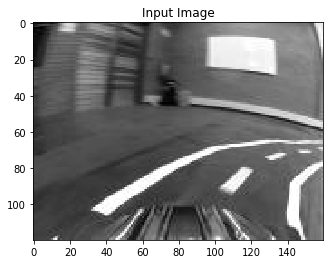

In [51]:
#Data Example
inImg = cv2.imread("101_cam-image_array_.jpg",0)
plt.title('Input Image')
plt.imshow(inImg, cmap = 'gray')

In [1]:
##What must be determined to achieve 'portability'?

#Lane Detection

#Background/Foreground Separation

The above image is fed into the neural network as-is. There is no help provided to the network in finding features such as lane lines etc. This means that the model is very constrained to the environment that it was trained in.

This problem can be solved by training it using many pictures from many different records collected over time and from other donkeycars - but this is time consuming and does not guarantee portability. A better method of making this model more 'portable' would be to incorporate a form of lane detection.

Lane detection can be accomplished by:
*Edge Detection
*Thresholding Images
*U-Net for Image Masking

Text(0.5, 0.98, 'Image Comparison: Canny Edge Detection')

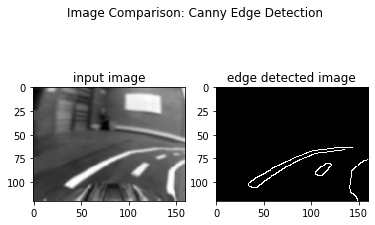

In [21]:
##Edge Detection

#Let's begin with edge detection. This is already built into some of the available parts for the donkey and makes use of 
#canny edge detection. We will show an example using the built-in opencv tools

imageIn = cv2.imread("101_cam-image_array_.jpg",0)
imageIn = cv2.GaussianBlur(imageIn, (5,5), 0)  #Gaussian Blur with a 5x5 kernel
edges = cv2.Canny(imageIn, 500, 200)    #Canny edge detection algorithm with threshold1 set that the strongest edges are found first

plt.subplot(121)
plt.title('input image')
plt.imshow(imageIn, cmap = 'gray')
plt.subplot(122)
plt.title('edge detected image')
plt.imshow(edges, cmap = 'gray')
plt.suptitle('Image Comparison: Canny Edge Detection')

In [12]:
##U-Net

#Setting Up Labels

#Training and Validation Data setup

#Network Design #1

#Network Training and Validation #1 - Dashboard of Results and Histograms - Live Validation/Training May Take too long

#Network Design and Dashboard #n

#Final Network Choice Based on Metrics

In [13]:
##Main Decision Network

#New Data Labeling and Organisation

#Network Design - Direct Model from Donkeycar

#Donkeycar Design Dashboard with intermediate features -single validation example

#Network Design - Own Design 1 

#Own Design 1 Dashboard with intermediate features - single validation example

#Own Design #n etc.


In [14]:
#Final Design Choices


In [15]:
#Compiled Full Pilot System - I.P.O and dashboard with selectable input images 